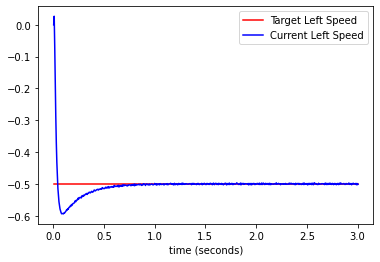

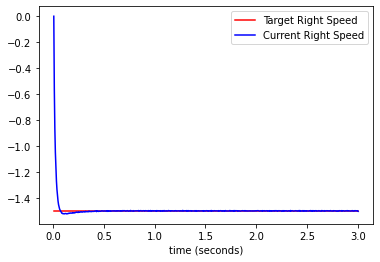

In [3]:
import sys
sys.path.append("../../")

#
# TO BE USED WITH godot/card2D_no_physics
#

from lib.data.dataplot import *
from lib.system.cart import *
from lib.system.controllers import *
from lib.dds.dds import *
from lib.utils.time import *

class PolarWheelSpeedControl:
    
    def __init__(self, _wheelbase, _kp, _ki, _kd, _sat):
        self.wheelbase = _wheelbase
        self.left_pid = PID_Controller(_kp, _ki, _kd, _sat)
        self.right_pid = PID_Controller(_kp, _ki, _kd, _sat)
        
    def evaluate(self, delta_t, target_linear, target_angular, current_left, current_right):
        self.target_left = target_linear - (target_angular * self.wheelbase) / 2.0
        self.target_right = target_linear + (target_angular * self.wheelbase) / 2.0
        out_left = self.left_pid.evaluate(delta_t, self.target_left - current_left)
        out_right = self.right_pid.evaluate(delta_t, self.target_right - current_right)
        return (out_left, out_right)

left_w = DataPlotter()
left_w.set_x("time (seconds)")
left_w.add_y("target_speed", "Target Left Speed")
left_w.add_y("current_speed", "Current Left Speed")

right_w = DataPlotter()
right_w.set_x("time (seconds)")
right_w.add_y("target_speed", "Target Right Speed")
right_w.add_y("current_speed", "Current Right Speed")

dds = DDS()
dds.start()

#dds.subscribe(['tick'])

wheel_speed_control = PolarWheelSpeedControl(0.5, 
                                             1.0, 5.0, 0.0, None)

cart2d = TwoWheelsCart2DEncodersOdometry(1.0, # 1 kg 
                                         0.3, # 30cm radius
                                         0.9, 0.8, # linear and angular friction
                                         0.04, 0.04, # traction wheels radius 4cm
                                         0.4, # traction wheels timebase 40cm
                                         0.03, 0.03, # encoder wheels radius 3cm
                                         0.5, # encoder wheels timebase 50cm
                                         4096) # resolution 4096 tick/rev

t = Time()
t.start()

# target speeds
target_v = -1.0
target_w = -2.0

while t.get() < 3:

    #dds.wait('tick')
    t.sleep(0.005)
    delta_t = t.elapsed()
    
    (current_left, current_right) = cart2d.get_wheel_speed()
    (torque_left, torque_right) = wheel_speed_control.evaluate(delta_t, 
                                                              target_v, target_w, 
                                                              current_left, current_right )

    cart2d.evaluate(delta_t, torque_left, torque_right)
    
    pose = cart2d.get_pose()
    dds.publish('X', pose[0], DDS.DDS_TYPE_FLOAT)
    dds.publish('Y', pose[1], DDS.DDS_TYPE_FLOAT)
    dds.publish('Theta', pose[2], DDS.DDS_TYPE_FLOAT)

    left_w.append_x(t.get())
    left_w.append_y("current_speed", current_left)
    left_w.append_y("target_speed", wheel_speed_control.target_left)
    
    right_w.append_x(t.get())
    right_w.append_y("current_speed", current_right)
    right_w.append_y("target_speed", wheel_speed_control.target_right)

dds.stop()

left_w.plot()
right_w.plot()
